# Neural network for remotely sensed data with texture information
Based on: _Miller, D. M., Kaminsky, E. J., & Rana, S. (1995). Neural network classification of remote-sensing data. Computers & Geosciences, 21(3), 377-386._

_**This is a modified version of the first models. In this version, texture information of each band is included as an input band for the neural network.**_

In [1]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import gdal
import tensorflow as tf
from tensorflow import keras
from skimage import io, util
from skimage.feature.texture import greycomatrix, greycoprops

First step is to organize our datasets, first we call in our Training dataset, our testing dataset and the training dataset labels (target labels). Both the training and testing datasets consist of the same area but the images where acquired at different times. **All of the datasets will be cropped off by a sliding window**. Since extracting the texture information from each band is very time consuming, only the bands 2, 3, 4 and 8 are selected from the 12 available, expecting a total of 16 bands per dataset.

In [2]:
# Function to load raster files as numpy arrays
def load_satrstr(filename):
    dataset = gdal.Open(filename, gdal.GA_ReadOnly)
    # Información de la imagen abierta
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    bands = dataset.RasterCount
    # Información de latitud y longitud
    geotransform = dataset.GetGeoTransform()
    xOrigin = geotransform[0]
    yOrigin = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    # Manipulación en forma de arreglo
    raster_array = dataset.ReadAsArray()
    return raster_array

In [3]:
file_test = r"D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\Texture analysis\Subset_S2B_MSIL2A_20200405T104619_N0214_R051_T31UES_20200405T134034_resampled_clip.tif"
file_train = r"D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\Texture analysis\Subset_S2B_MSIL2A_20200515T104619_N0214_R051_T31UES_20200515T135604_resampled_clip.tif"
file_test_ft = r"D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\Texture analysis\Subset_S2B_MSIL2A_20200405T104619_N0214_R051_T31UES_20200405T134034_resampled_clip_glcm.tif"
file_train_ft = r"D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\Texture analysis\Subset_S2B_MSIL2A_20200515T104619_N0214_R051_T31UES_20200515T135604_resampled_clip_glcm.tif"
file_lbl = r"D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\S2GLC_T31UES_2017\S2GLC_T31UES_2017_corrected_clip.tif"

# Loading the arrays using the defined function
test_img = load_satrstr(file_test)
test_ft = load_satrstr(file_test_ft)
train_img = load_satrstr(file_train)
train_ft = load_satrstr(file_train_ft)
train_lbl = load_satrstr(file_lbl)

# Resulting array dimentions:
print(test_img.shape)
print(test_ft.shape)
print(train_img.shape)
print(train_ft.shape)
print(train_lbl.shape)

(10, 2170, 2286)
(30, 2170, 2286)
(10, 2170, 2286)
(30, 2170, 2286)
(2170, 2286)


So far, we can see that we have 2 datasets (training and testing) with of 12 bands of $2286 \times 2170$ pixels each. Along with our label dataset: an image of the same dimensions with integer values ranging from 1 to 9, where each integer represents a different class.

## Textural features image 

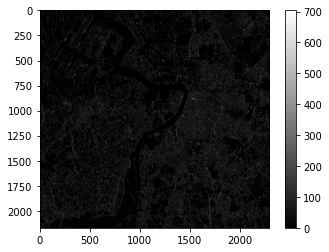

In [4]:
plt.figure()
plt.imshow(train_ft[0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

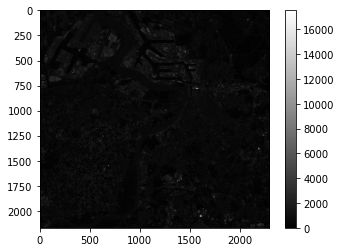

In [5]:
plt.figure()
plt.imshow(train_img[0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## Preparing the arrays as input for the neural network

We need to normalize the values in the arrays in values from 0 to 1, we use the computed max value for each dataset to obtain such result.

In [6]:
maxpv_train = np.amax(train_img) # Max pixel value for train image ds
maxpv_test = np.amax(test_img) # Max pixel value for test image ds

train_img = train_img / maxpv_train
test_img = test_img / maxpv_test

# For the feature datasets we must do it differently, since the values range differently for each of the feature types (Contrast, Correlation and ASM)
train_nft = train_ft / train_ft.max(axis=0) # Normalized features array
test_nft = test_ft / test_ft.max(axis=0)

We can notice that the feature datasets have similar dimensions than our image datasets. Now we must concatenate both datasets along the band axis (the features dataset will count as individual bands of the image), the resulting dataset will be used to train/test our neural network.

In [7]:
# Concatenating the training array
train_arr = np.concatenate((train_img, train_nft), axis=0)
train_arr = train_arr.reshape(40, 4960620)
train_arr = np.nan_to_num(train_arr) # Casting NaN values to 0
train_arr = train_arr.T
print(train_arr.shape)

# Concatenating the testing array
test_arr = np.concatenate((test_img, test_nft), axis=0)
test_arr = test_arr.reshape(40, 4960620)
test_arr = np.nan_to_num(test_arr)
test_arr = test_arr.T
print(test_arr.shape)

# Reshaping and fixing label array
train_lbl = train_lbl.reshape(4960620) - 1
np.clip(train_lbl, 0, 8, out=train_lbl)
train_lbl = train_lbl.astype('int64')

(4960620, 40)
(4960620, 40)


In [8]:
np.unique(train_lbl)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [9]:
np.amax(test_arr)

1.0

By this point, we have all we need to train and test our neural network

## Model selection
Since in the best result was obtained from the Model 2 Neural network we will use the very same in this approach, modifying only the dimension of the input data from 12 to 16.

In [10]:
# Model build
model = keras.Sequential([
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(250, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

# Model compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(train_arr, train_lbl, epochs=10) # Fitting time can be cut down by reducing the epochs

Train on 4960620 samples
Epoch 1/10
4960620/4960620 [==============================] - 432s 87us/sample - loss: 0.8196 - accuracy: 0.7113
Epoch 2/10
4960620/4960620 [==============================] - 408s 82us/sample - loss: 0.7740 - accuracy: 0.7257
Epoch 3/10
4960620/4960620 [==============================] - 391s 79us/sample - loss: 0.7634 - accuracy: 0.7291
Epoch 4/10
4960620/4960620 [==============================] - 409s 82us/sample - loss: 0.7585 - accuracy: 0.7308
Epoch 5/10
4960620/4960620 [==============================] - 439s 89us/sample - loss: 0.7562 - accuracy: 0.7320
Epoch 6/10
4960620/4960620 [==============================] - 435s 88us/sample - loss: 0.7549 - accuracy: 0.7327
Epoch 7/10
4960620/4960620 [==============================] - 421s 85us/sample - loss: 0.7517 - accuracy: 0.7333
Epoch 8/10
4960620/4960620 [==============================] - 430s 87us/sample - loss: 0.7496 - accuracy: 0.7337
Epoch 10/10
4960620/4960620 [==============================] - 410s 83u

## Testing the neural network

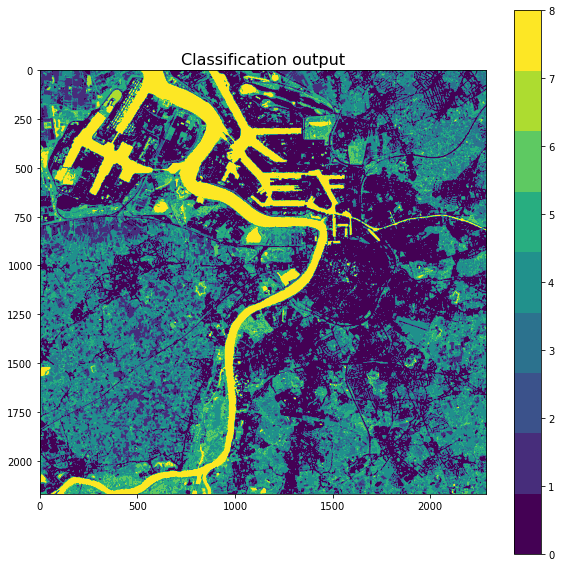

In [14]:
# First, the predictions are made
predictions = model.predict(test_arr)
# This is necessary since the output of each pixel is a vector of length N where N is the number of classes. The one with the highest value is the one selected to represent the pixel
pred_raster = np.argmax(predictions, axis=1)
# Reshaping is necessary to plot the final output
pred_raster = pred_raster.reshape(2170, 2286)
# Finally we visualize the result
plt.figure(figsize = (10,10))
plt.imshow(pred_raster, vmin=0, vmax=8, cmap=plt.cm.get_cmap('viridis', 9))
plt.colorbar()
plt.grid(False)
plt.title('Classification output', fontsize=16)
plt.show()

## Results assessment

In [15]:
dataset = gdal.Open(file_train, gdal.GA_ReadOnly)

# pred_raster =  pred_raster.reshape(2170,2286)
dst_filename = 'D:\RESPALDO EDUARDO 2018\Documentos\MML\ProyectoFinal\M2P1.tiff'
x_pixels = 2170  # number of pixels in x
y_pixels = 2286  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
outds = driver.Create(dst_filename,y_pixels, x_pixels, 1,gdal.GDT_Float32)
outds.GetRasterBand(1).WriteArray(pred_raster)

# follow code is adding GeoTranform and Projection
geotrans=dataset.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=dataset.GetProjection() #you can get from a exsited tif or import 
outds.SetGeoTransform(geotrans)
outds.SetProjection(proj)
outds.FlushCache()
outds=None

Global accuracy of model 1:  0.5866869463897658


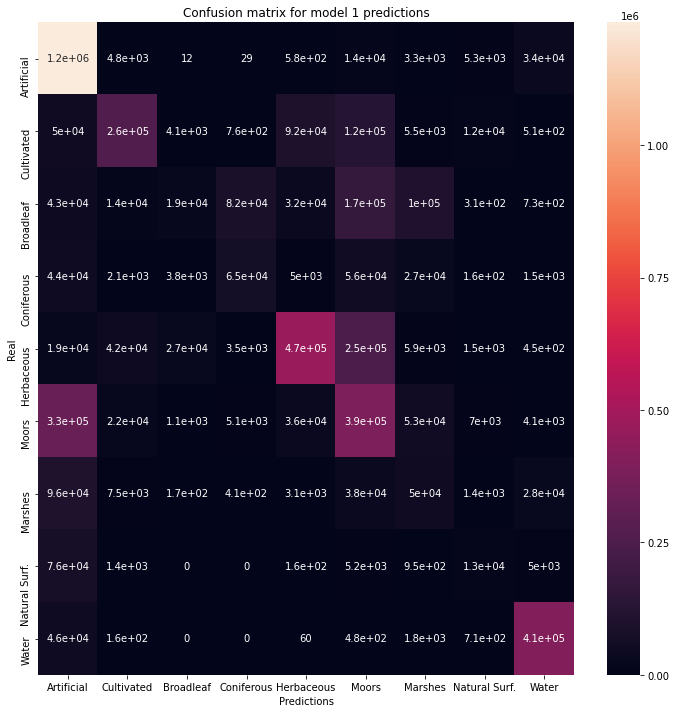

In [16]:
# We load sk learn library for cm and seaborn for data presentation
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_lbl = train_lbl.reshape(4960620).astype('int64')
pred_raster = pred_raster.reshape(4960620).astype('int64')

# We build the confusion matrices
cm = confusion_matrix(train_lbl, pred_raster) # Confusion matrix for model 1 predictions
# We calculate global accuracies
ga = np.trace(cm)/4960620 # Global accuracy of model 1
# Now we plot the results

# Model pred
fig1, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,12))
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
print("Global accuracy of model 1: ", ga)
ax.set_xlabel('Predictions');ax.set_ylabel('Real'); 
ax.set_title('Confusion matrix for model 1 predictions'); 
ax.xaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']); 
ax.yaxis.set_ticklabels(['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']);


In [17]:
T_Artif = np.count_nonzero(train_lbl == 0) # Total "Artificial" pixels on our label dataset
T_Cultv = np.count_nonzero(train_lbl == 1)
T_BroadL = np.count_nonzero(train_lbl == 2)
T_Conif = np.count_nonzero(train_lbl == 3)
T_Herb = np.count_nonzero(train_lbl == 4)
T_Moors = np.count_nonzero(train_lbl == 5)
T_Marshes = np.count_nonzero(train_lbl == 6)
T_NatS = np.count_nonzero(train_lbl == 7)
T_Water = np.count_nonzero(train_lbl == 8)

ac_Artif = cm[0][0] / T_Artif # "Artificial" class accuracy
ac_Cultv = cm[1][1] / T_Cultv
ac_BroadL = cm[2][2] / T_BroadL
ac_Conif = cm[3][3] / T_Conif
ac_Herb = cm[4][4] / T_Herb
ac_Moors = cm[5][5] / T_Moors
ac_Marshes = cm[6][6] / T_Marshes
ac_NatS = cm[7][7] / T_NatS
ac_Water = cm[8][8] / T_Water

class_labels = ['Artificial', 'Cultivated', 'Broadleaf', 'Coniferous', 'Herbaceous', 'Moors', 'Marshes', 'Natural Surf.', 'Water']

In [18]:
import pandas as pd
accuracies = [ac_Artif, ac_Cultv, ac_BroadL, ac_Conif, ac_Herb, ac_Moors, ac_Marshes, ac_NatS, ac_Water]
df = pd.DataFrame(accuracies, index = class_labels, columns = ['Accuracy']) 
df

,Accuracy
Artificial,0.951943
Cultivated,0.473476
Broadleaf,0.041455
Coniferous,0.318481
Herbaceous,0.578809
Moors,0.461278
Marshes,0.220664
Natural Surf.,0.124352
Water,0.891791
